# Analysis of Beta Series Correlations

This notebook walks through the exploration of beta series correlations extracted from both task and rest data.
The rest data was treated like the task data, that is, any event that happened during the task we pretend the event also happened during rest.

The expectation is that beta series correlations from a task will "look different" from the beta series correlations from rest.
Demonstrating the difference will provide a validity check for [NiBetaSeries](https://nibetaseries.readthedocs.io/en/stable/).

I will attempt to measure the difference between task and rest with multiple approaches.

1. The average within/between network correlations will be different between task and rest
  - specifically I expect both the between and within network correlations to be higher during task, since there is a low likelihood of there being a BOLD response during the resting state data.
2. The correlation contrast between task and rest will different from zero.
  - To maximize the potential to detect a difference, subtracting the rest correlation matrix from the task correlation matrix from every participant _should_ result in the greatest possible difference.
  - I will use an activation atlas and the schaefer atlas to make sure results/conclusions are robust
3. The correlation contrasts between task/rest, switch/single, repeat/single, and switch/repeat will have more positives using LSS relative to LSA.

**UPDATE:**

The first hypothesis has no visual support, in fact, as you will see the average within network correlation is greater for the resting state data.
The average between network correlation also does not appear to be different between the two.

Since the rest data beta series had more structure than anticipated, a couple graph theoretical measures were added.

4. The participation coefficient for the task data should be closer to 1 relative to the rest data.
   This supports the finding by Wig (2017)
5. Conversly, the clustering coefficient should be lower for the task data relative to the rest data.
6. Modularity should also be lower for the task data

## Settings/Constants
You will probably need to change these settings to have the notebook work for you.

In [267]:
import os
# have to set the R path before I can use notebook_functions
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH

# other constants

# number of threads you wish to parallelize across
N_THREADS = 32

# paths to the results
LSS_SCH_PATH = '../lss-schaeferparcel-400/nibetaseries'
LSA_SCH_PATH = '../lsa-schaeferparcel-400/nibetaseries'

LSS_ACT_PATH = '../lss-overallresponse/nibetaseries'
LSA_ACT_PATH = '../lsa-overallresponse/nibetaseries'

# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# path to participants file
PARTICIPANT_DEMO = '../../participants.tsv'

# absolute max the z-value can be for fisher's r->z transform
THRESH = 2.647

# activation atlas
ACT_ATLAS = '../data/overall_response_atlas.nii.gz'


OVERWRITE_IMAGES = False

## Libraries
These are the packages used in this notebook, including `notebook_functions` which isolates some repeated code sections to keep the notebook clearer.

In [268]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from bids.layout import BIDSLayout
from sklearn.metrics import confusion_matrix
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import notebook_functions as nf


In [269]:
import importlib
importlib.reload(nf)

<module 'notebook_functions' from '/home/jdkent/hpchome/bids/derivatives/nibsAnalysis/notebook_functions.py'>

## Find/Aggregate the files

pybids is an awesome tool to index and query the data on your computer.
The layout variables contain all the information needed to extract where my correlation files are and what attributes they have (e.g., are they from task or rest, are they from the repeat or switch trial type, etc.)

### load the bold qa measures

In [270]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

,bids_name,aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,...,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr,task,participant_id
0,sub-GE120001_ses-pre_task-fauxbold_bold,0.001063,0.006351,2,16.187316,1.198663,1.010760,0.448331,3009467.75,0.103818,...,232.520432,1381.902222,1410.488159,29195.0,837.753119,1812.366785,297.530945,64.075073,fauxbold,GE120001
3,sub-GE120001_ses-pre_task-taskswitch_bold,0.003942,0.005572,2,15.734272,1.148948,0.957532,0.450887,1364181.25,0.138379,...,216.930939,1391.725708,1421.432861,29084.0,868.629898,1788.999225,284.924835,72.902779,taskswitch,GE120001
4,sub-GE120002_ses-pre_task-fauxbold_bold,0.002056,0.010868,1,17.975215,1.024274,1.143355,0.432753,3026978.75,0.227028,...,225.343140,1283.572998,1322.169800,27338.0,738.498715,1686.504254,287.157501,47.578674,fauxbold,GE120002
7,sub-GE120002_ses-pre_task-taskswitch_bold,0.002134,0.004827,1,16.918552,1.176876,0.990735,0.431836,4213331.00,0.169619,...,229.552505,1292.104004,1334.634033,27340.0,734.595834,1700.930396,292.718201,71.898445,taskswitch,GE120002
8,sub-GE120003_ses-pre_task-fauxbold_bold,0.003094,0.018135,1,38.223070,1.116687,0.909317,0.393451,2381240.50,0.577373,...,246.342178,1247.227295,1309.490601,23125.0,595.968738,1648.415723,314.057434,31.255548,fauxbold,GE120003


In [271]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

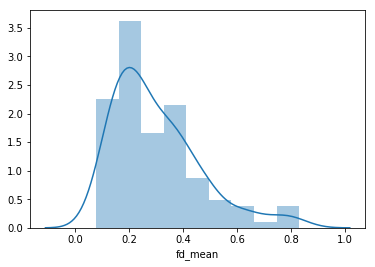

In [272]:
sns.distplot(bold_qa['fd_mean'])

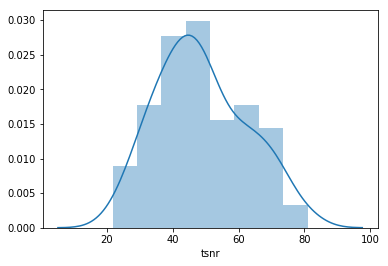

In [273]:
sns.distplot(bold_qa['tsnr'])

In [274]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [275]:
# drop the num measurement
bold_qa_select.drop(columns='fd_num', inplace=True)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### load the participants tsv


In [276]:
participant_df = pd.read_csv(PARTICIPANT_DEMO, sep='\t')
participant_df_select = participant_df[["participant_id", "sex", "age", "education"]]
participant_df.head()

,participant_id,sex,gender,age,education
0,GE120008,Female,Female,81,12
1,GE120007,Male,Male,83,14
2,GE120045,Male,Male,76,18
3,GE120046,Male,Male,74,21
4,GE120070,Male,Male,71,17


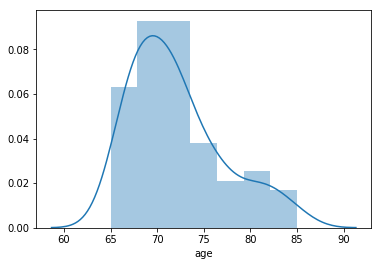

In [277]:
sns.distplot(participant_df['age'])

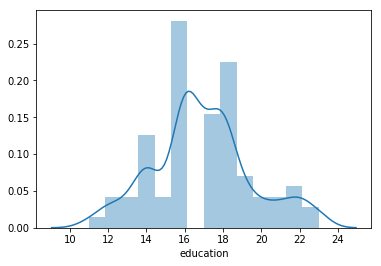

In [278]:
sns.distplot(participant_df['education'])

### Get the correlation files

In [279]:
lss_sch_layout = BIDSLayout(LSS_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lsa_sch_layout = BIDSLayout(LSA_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lss_act_layout = BIDSLayout(LSS_ACT_PATH, validate=False, config=['bids', 'derivatives'])
lsa_act_layout = BIDSLayout(LSA_ACT_PATH, validate=False, config=['bids', 'derivatives'])

In [280]:
ent = lss_sch_layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [311]:
# fb=fauxbold, ts=taskswitch
# act=activation, sch=schaefer
# lss=least squares separate, lsa=least squares all
fb_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",)
#                                        subject=good_participants)

fb_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",)
#                                        subject=good_participants)

ts_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",)
#                                        subject=good_participants)

ts_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",)
#                                        subject=good_participants)

fb_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",)
 #                                       subject=good_participants)

fb_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",)
 #                                       subject=good_participants)

ts_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",)
#                                        subject=good_participants)

ts_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",)
#                                        subject=good_participants)

### Describe Demographics of the used participants

In [282]:
participant_df_select[participant_df_select['participant_id'].isin(ent)].describe(include='all')

,participant_id,sex,age,education
count,61,61,61.000000,61.000000
unique,61,2,NaN,NaN
top,GE120061,Female,NaN,NaN
freq,1,31,NaN,NaN
mean,NaN,NaN,71.754098,17.065574
std,NaN,NaN,4.766745,2.657498
min,NaN,NaN,65.000000,12.000000
25%,NaN,NaN,69.000000,16.000000
50%,NaN,NaN,71.000000,17.000000
75%,NaN,NaN,73.000000,18.000000


In [283]:
participant_df_select = participant_df_select[participant_df_select['participant_id'].isin(good_participants)]

In [284]:
participant_df_select.describe(include='all')

,participant_id,sex,age,education
count,40,40,40.000000,40.000000
unique,40,2,NaN,NaN
top,GE120025,Female,NaN,NaN
freq,1,21,NaN,NaN
mean,NaN,NaN,71.025000,16.950000
std,NaN,NaN,4.514861,2.745159
min,NaN,NaN,65.000000,12.000000
25%,NaN,NaN,68.000000,16.000000
50%,NaN,NaN,69.500000,17.000000
75%,NaN,NaN,72.250000,18.000000


## 1. Average within/between network correlations for task and null
I expect both the between and within network correlations to be higher during task, since there is a low likelihood of there being a BOLD response during the resting state data, and beta should not have a good fit for the rest data.
I'm only using the schaefer atlas for this hypothesis to measure the entire cortex.

In [231]:
# summarize the task data
with Pool(N_THREADS) as p:
    ts_dfs = p.starmap(nf.summarize_network_correlations,
                       [(f.path, f.entities['subject']) for f in ts_sch_lss_objs['switch']])
taskswitch_df = pd.concat(ts_dfs)
taskswitch_df.head()

Process ForkPoolWorker-4218:
Process ForkPoolWorker-4223:
Process ForkPoolWorker-4215:
Process ForkPoolWorker-4214:
Process ForkPoolWorker-4224:
Process ForkPoolWorker-4200:
Process ForkPoolWorker-4216:
Traceback (most recent call last):
Process ForkPoolWorker-4206:
Process ForkPoolWorker-4202:
Process ForkPoolWorker-4201:
Process ForkPoolWorker-4212:
Process ForkPoolWorker-4210:
Process ForkPoolWorker-4207:
Process ForkPoolWorker-4217:
Process ForkPoolWorker-4211:
Process ForkPoolWorker-4203:
Process ForkPoolWorker-4209:
Process ForkPoolWorker-4213:
Process ForkPoolWorker-4199:
Process ForkPoolWorker-4208:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-4205:
Process ForkPoolWorker-4195:
Traceback (most recent call last):
Process ForkPoolWorker-4198:
Process ForkPoolWorker-4194:
Process ForkPoolWorker-4197:
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process F

  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = g

  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
KeyboardInterrupt
  File "/home/jdkent/.conda/envs/aim1_valid/lib/python

KeyboardInterrupt: 

In [ ]:
# summarize the rest data
with Pool(N_THREADS) as p:
    fb_dfs = p.starmap(nf.summarize_network_correlations,
                       [(f.path, f.entities['subject']) for f in fb_sch_lss_objs['switch']])
fauxbold_df = pd.concat(fb_dfs)
fauxbold_df.head()

In [143]:
# combine taskswitch and fauxbold (task and rest)
taskswitch_df['data'] = ['taskswitch'] * taskswitch_df.shape[0]
fauxbold_df['data'] = ['fauxbold'] * fauxbold_df.shape[0]
data_df = pd.concat([taskswitch_df, fauxbold_df])

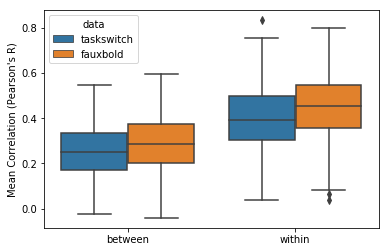

In [144]:
ax = sns.boxplot(x="network_connection", y="mean", hue='data', data=data_df)
ax.set_ylabel("Mean Correlation (Pearson's R)");
ax.set_xlabel("");


In [145]:
if not os.path.isfile("outputs/within_between.png") or OVERWRITE_IMAGES:
    ax.figure.savefig("outputs/within_between.png", dpi=1200)

### Overall within/between network correlations do not support hypothesis 1

The average within network correlations turn out to be a little **higher** in rest relative to task, contrary to my hypothesis.
In addition, the average between network correlation does not appear to differ betweentask and rest.

### Split average within/between correlation by network
This will identify whether there are some networks during rest that have higher within network correlations relative to task and some vice versa, or if the pattern is consistent throughout.

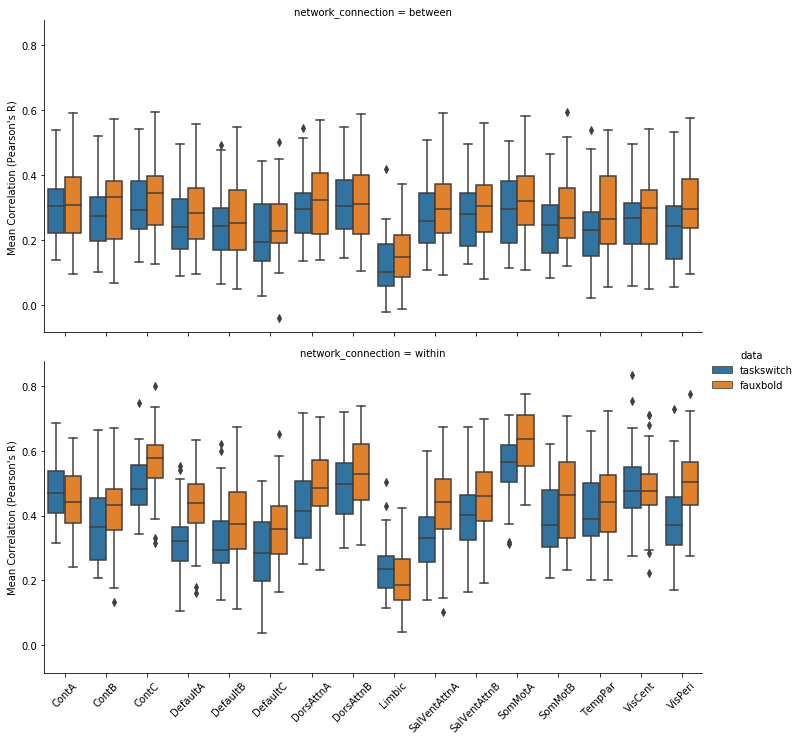

In [146]:
g = sns.catplot(kind='box', height=5, aspect=2,
            x='source_network', y='mean', row='network_connection',
            hue='data', data=data_df)

for ax in g.axes.flatten():
    ax.set_ylabel("Mean Correlation (Pearson's R)");

g.axes[1][0].set_xlabel("");
g.axes[1][0].set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45);


In [147]:
if not os.path.isfile("outputs/within_between_networks.png") or OVERWRITE_IMAGES:
    g.savefig("outputs/within_between_networks.png", bbox_inches="tight", dpi=1200)

### Average within/between network correlation do not differ across networks
The rest within network correlations appear **higher** than the task within network correlations across all networks.

## The condition contrast within the task will be greater than the condition contrast within rest
The task had multiple trial types (single, repeat, switch).
If beta series is able to pull out differences between trial types, the difference between switch and repeat during the task should be greater than the difference between "switch" and "repeat" during rest, since no actual events occurred during rest.

In [148]:
# task (switch - repeat)
with Pool(N_THREADS) as p:
    ts_diff_matrices = p.starmap(nf.calc_diff_matrices,
                                 [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(ts_sch_lss_objs['switch'], ts_sch_lss_objs['single'])])

taskswitch_diff = pd.concat(ts_diff_matrices)

In [149]:
# rest (switch - repeat)
with Pool(N_THREADS) as p:
    fb_diff_matrices = p.starmap(nf.calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(fb_sch_lss_objs['switch'], fb_sch_lss_objs['single'])])

fauxbold_diff = pd.concat(fb_diff_matrices)

In [150]:
taskswitch_diff['data'] = ['taskswitch'] * taskswitch_diff.shape[0]
fauxbold_diff['data'] = ['fauxbold'] * fauxbold_diff.shape[0]

In [151]:
diff_switch_repeat = pd.concat([taskswitch_diff, fauxbold_diff])
diff_switch_repeat.head()

,index,network_connection,source_network,mean,participant_id,mean_r,data
0,0,between,ContA,-0.012150,GE120001,-0.012150,taskswitch
1,1,between,ContB,-0.016214,GE120001,-0.016213,taskswitch
2,2,between,ContC,-0.010123,GE120001,-0.010123,taskswitch
3,3,between,DefaultA,0.021178,GE120001,0.021175,taskswitch
4,4,between,DefaultB,0.017119,GE120001,0.017117,taskswitch


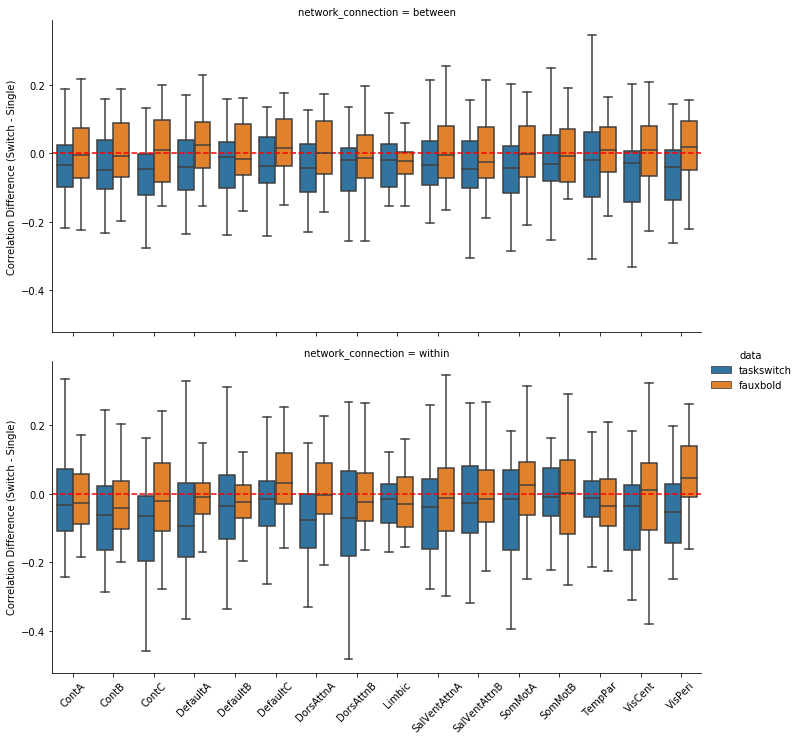

In [152]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean_r', row='network_connection', showfliers=False, hue='data', data=diff_switch_repeat)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--');
    ax.set_ylabel("Correlation Difference (Switch - Single)");

fg.axes[1][0].set_xlabel("");
fg.axes[1][0].set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45);

In [153]:
if not os.path.isfile("outputs/switch_repeat_difference.png") or OVERWRITE_IMAGES:
    fg.savefig("outputs/switch_repeat_difference.png", bbox_inches="tight", dpi=1200)

## 2. The correlation contrast between task and rest will be different from zero


In [154]:
with Pool(N_THREADS) as p:
    tsf_diff_matrices = p.starmap(nf.calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(ts_sch_lss_objs['switch'], fb_sch_lss_objs['switch'])])


task_faux_diff = pd.concat(tsf_diff_matrices)
task_faux_diff.head()

,index,network_connection,source_network,mean,participant_id,mean_r
0,0,between,ContA,-0.067740,GE120001,-0.067637
1,1,between,ContB,-0.142772,GE120001,-0.141810
2,2,between,ContC,-0.045644,GE120001,-0.045613
3,3,between,DefaultA,-0.063904,GE120001,-0.063817
4,4,between,DefaultB,-0.077827,GE120001,-0.077670


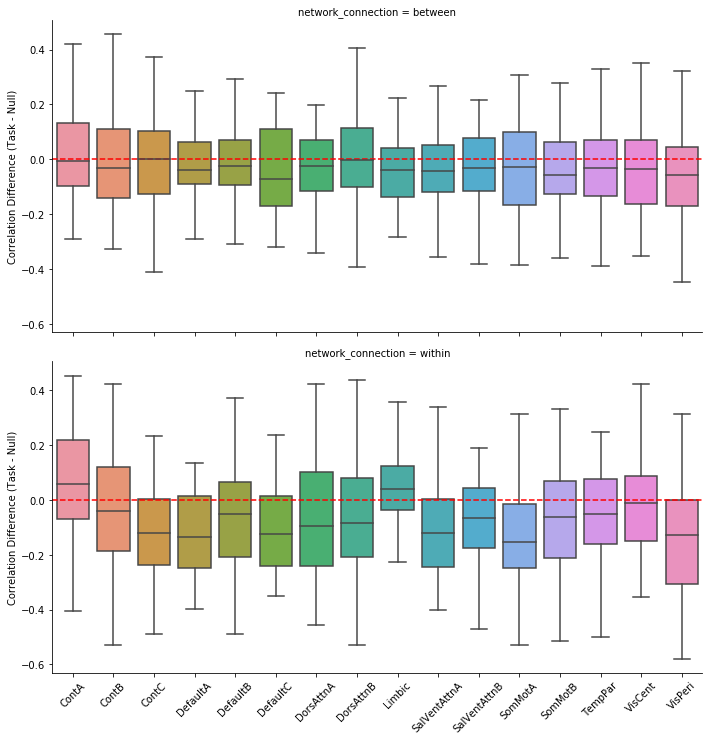

In [155]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean_r', row='network_connection', showfliers=False, data=task_faux_diff)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--');
    ax.set_ylabel("Correlation Difference (Task - Null)");

fg.axes[1][0].set_xlabel("");
fg.axes[1][0].set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45);

In [156]:
if not os.path.isfile("outputs/task_rest_difference.png") or OVERWRITE_IMAGES:
    fg.savefig("outputs/task_rest_difference.png", bbox_inches="tight", dpi=600)

## model correlation differences between task and null

In [ ]:
switch_wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['switch'], 'taskswitch'), nf.bind_matrices(fb_sch_lss_objs['switch'], 'fauxbold')])
switch_wide_df.head()

In [190]:
# bind qa measures
switch_wide_nr_df = pd.merge(switch_wide_df, bold_qa_select, how='left', on=['participant_id', 'task'])
switch_wide_nr_df = pd.merge(switch_wide_nr_df, participant_df_select, how='left', on=['participant_id'])

### Do not include nuisance regressors

In [ ]:
model_df = nf.model_corr_diff_mt(switch_wide_df, N_THREADS)

In [ ]:
p_value_df = nf.make_symmetric_df(model_df, "p_value")
estimate_df = nf.make_symmetric_df(model_df, "estimate")
display(p_value_df.head())
display(estimate_df.head())

In [ ]:
f = nf._make_pretty_schaefer_heatmap(p_value_df, vmin=0.0, vmax=0.05, cmap="YlGnBu")

In [ ]:
if not os.path.isfile("outputs/task_null_difference_heatmap_pval.png") or OVERWRITE_IMAGES:
    f.savefig("outputs/task_null_difference_heatmap_pval.png", bbox_inches="tight", dpi=600)

In [ ]:
f = nf._make_pretty_schaefer_heatmap(estimate_df)

In [196]:
if not os.path.isfile("outputs/task_rest_difference_heatmap_estimates.png") or OVERWRITE_IMAGES:
    f.savefig("outputs/task_rest_difference_heatmap_estimates.png", bbox_inches="tight", dpi=600)

In [197]:
idxs = np.triu_indices(p_value_df.shape[0], k=1)
# false discovery rate (Benjamini/Hochberg)
p_values_sig, p_value_fdr, _, _ = multipletests(p_value_df.values[idxs], alpha=0.05, method='fdr_bh')
# show the fdr corrected values
p_value_fdr[p_values_sig]

array([5.34919905e-03, 4.35492882e-03, 3.39902397e-03, ...,
       2.58885050e-02, 8.61005902e-06, 4.53684665e-03])

In [198]:
p_value_fdr[p_values_sig].shape

(17577,)

### Include framewise displacement, tsnr, age, sex, and education

In [199]:
model_nr_df = nf.model_corr_diff_mt(switch_wide_nr_df, N_THREADS, ['fd_mean', 'tsnr', 'age', 'sex', 'education'])

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "sex". Fall back to string conversion. The error is: Series can only be of one type, or None.
  % (name, str(e)))
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "sex". Fall back to string conversion. The error is: Series can only be of one type, or None.
  % (name, str(e)))
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "sex". Fall back to string conversion. The error is: Series can only be of one type, or None.
  % (name, str(e)))
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "sex". Fall back to string conversion. The error is: Series ca

AttributeError: 'float' object has no attribute 'encode'

In [ ]:
p_value_nr_df = nf.make_symmetric_df(model_nr_df, "p_value")
estimate_nr_df = nf.make_symmetric_df(model_nr_df, "estimate")
display(p_value_nr_df.head())
display(estimate_nr_df.head())

In [ ]:
f = nf._make_pretty_schaefer_heatmap(p_value_nr_df, vmin=0.0, vmax=0.05, cmap="YlGnBu")

In [ ]:
# false discovery rate (Benjamini/Hochberg)
p_values_sig, p_value_fdr, _, _ = multipletests(p_value_nr_df.values[idxs], alpha=0.05, method='fdr_bh')
# still significant differences...
display(p_value_fdr[p_values_sig].shape)


## 3. The correlation contrasts between task/null, switch/single, repeat/single, and switch/repeat will have more positives using LSS relative to LSA.

###  Schaefer Atlas: task - null

Number of Positives lsa: 7172 / 79800
Number of Positives lss: 13119 / 79800
Number of overlapping positives: 2982 / 79800


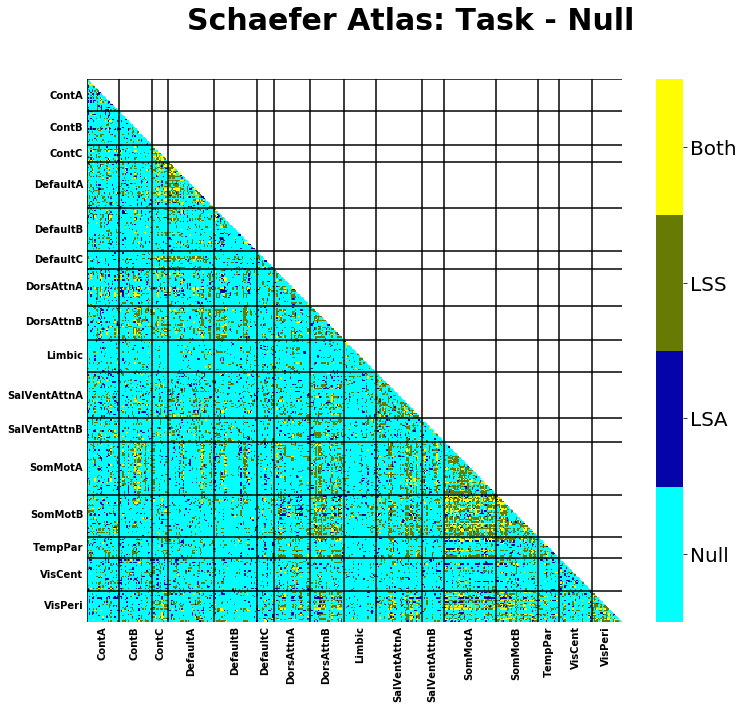

In [312]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       fb_sch_lss_objs['switch'],
                       ts_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['switch'],
                       'task', 'null',
                       rois='schaefer', nthreads=N_THREADS)
fig.suptitle("Schaefer Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-schaefer_contrast-taskXnull.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

###  Activation Atlas: task - null

Number of Positives lsa: 15 / 210
Number of Positives lss: 18 / 210
Number of overlapping positives: 3 / 210


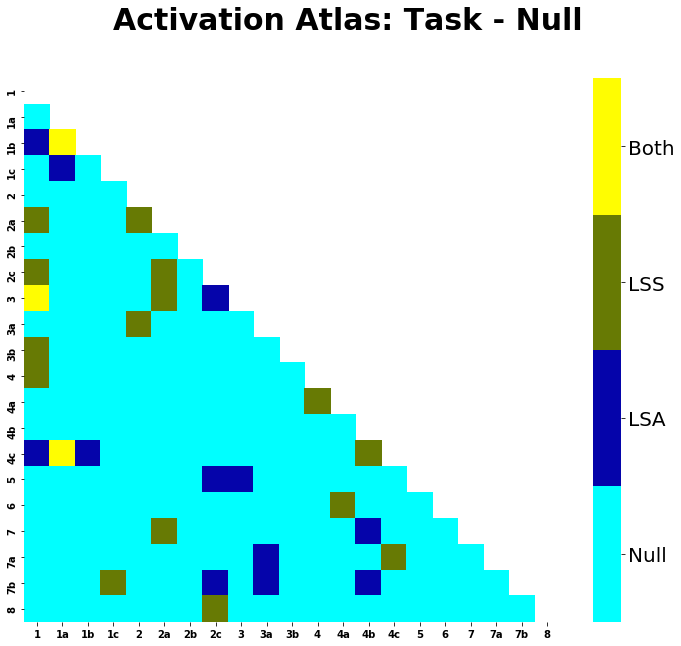

In [313]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       fb_act_lss_objs['switch'],
                       ts_act_lsa_objs['switch'],
                       fb_act_lsa_objs['switch'],
                       'task', 'null',
                       rois='activation', nthreads=N_THREADS)
fig.suptitle("Activation Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-activation_contrast-taskXnull.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Schaefer Atlas: switch - single (task)

Number of Positives lsa: 2969 / 79800
Number of Positives lss: 4236 / 79800
Number of overlapping positives: 299 / 79800


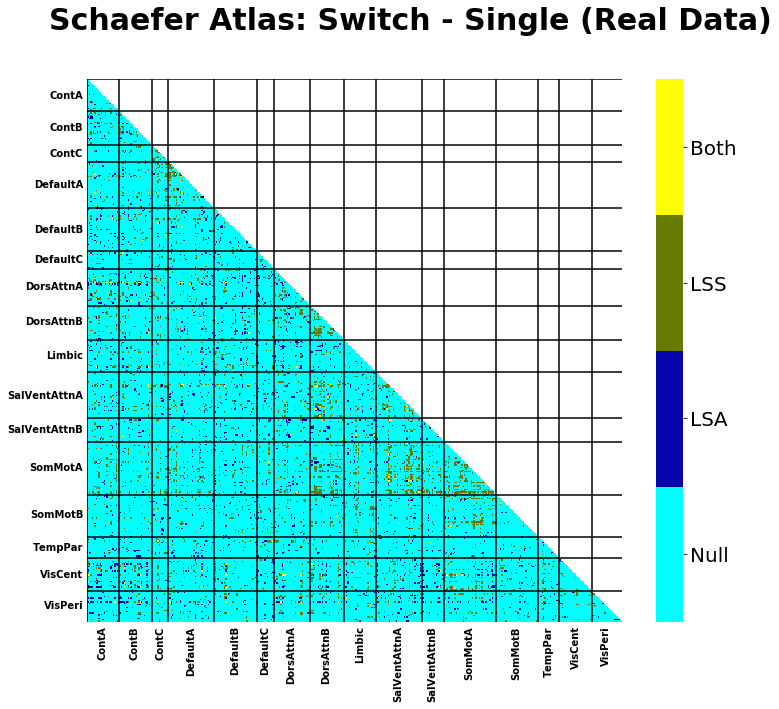

In [314]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['switch'],
                       ts_sch_lsa_objs['single'],
                       'switch', 'single',
                       rois='schaefer', nthreads=N_THREADS)
fig.suptitle("Schaefer Atlas: Switch - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchXsingle.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Schaefer Atlas: switch - single (null)

Number of Positives lsa: 1621 / 79800
Number of Positives lss: 3096 / 79800
Number of overlapping positives: 122 / 79800


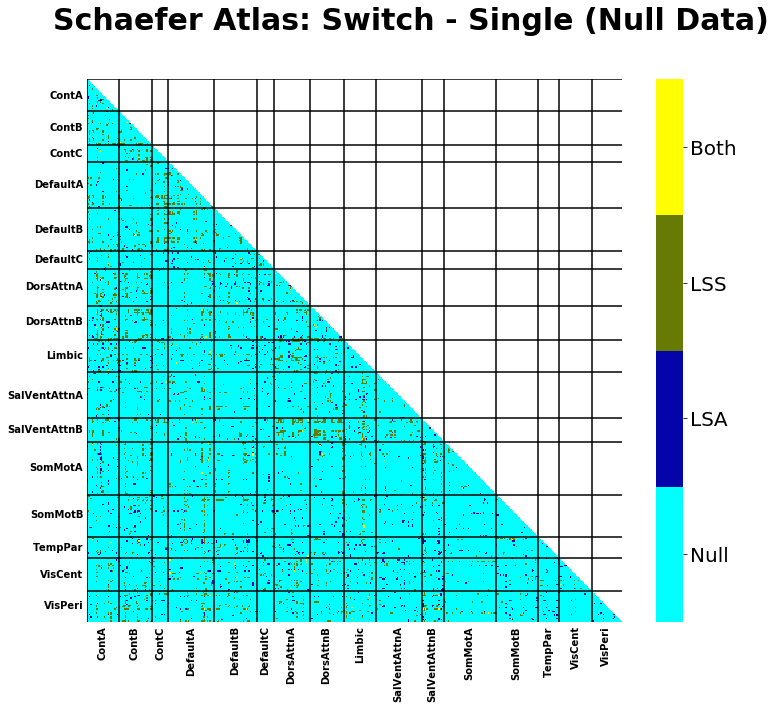

In [315]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['switch'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['single'],
                       'switch', 'single',
                       rois='schaefer', nthreads=N_THREADS)
fig.suptitle("Schaefer Atlas: Switch - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-switchXsingle.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Activation Atlas: switch - single (task)

Number of Positives lsa: 5 / 210
Number of Positives lss: 11 / 210
Number of overlapping positives: 0 / 210


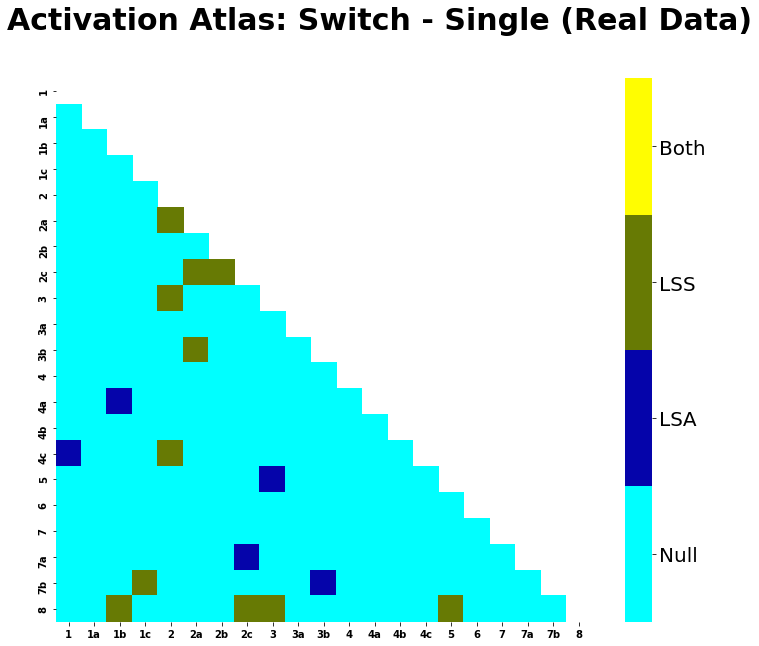

In [316]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['switch'],
                       ts_act_lsa_objs['single'],
                       'switch', 'single',
                       rois='activation', nthreads=N_THREADS)
fig.suptitle("Activation Atlas: Switch - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-switchXsingle.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Activation Atlas: switch - single (null)

Number of Positives lsa: 6 / 210
Number of Positives lss: 7 / 210
Number of overlapping positives: 0 / 210


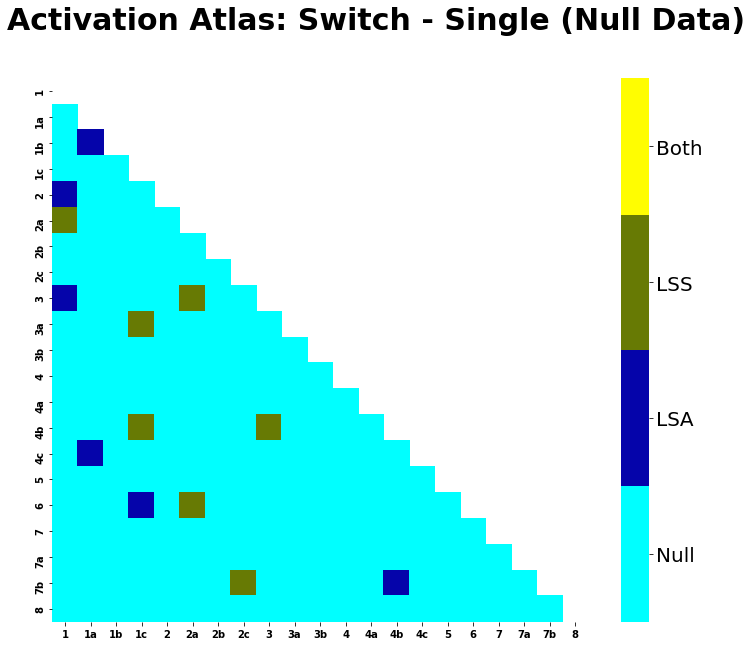

In [317]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['switch'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['switch'],
                       fb_act_lsa_objs['single'],
                       'switch', 'single',
                       rois='activation', nthreads=N_THREADS)
fig.suptitle("Activation Atlas: Switch - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-switchXsingle.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Schaefer Atlas: repeat - single (task)

Number of Positives lsa: 3698 / 79800
Number of Positives lss: 3823 / 79800
Number of overlapping positives: 261 / 79800


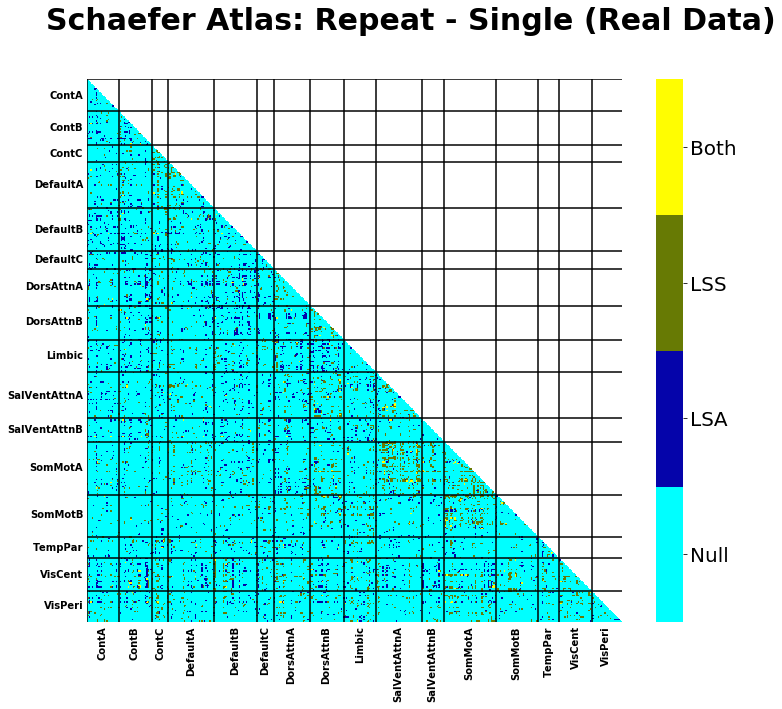

In [318]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['repeat'],
                       ts_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS)
fig.suptitle("Schaefer Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-repeatXsingle.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Schaefer Atlas: repeat - single (null)

Number of Positives lsa: 2424 / 79800
Number of Positives lss: 4667 / 79800
Number of overlapping positives: 357 / 79800


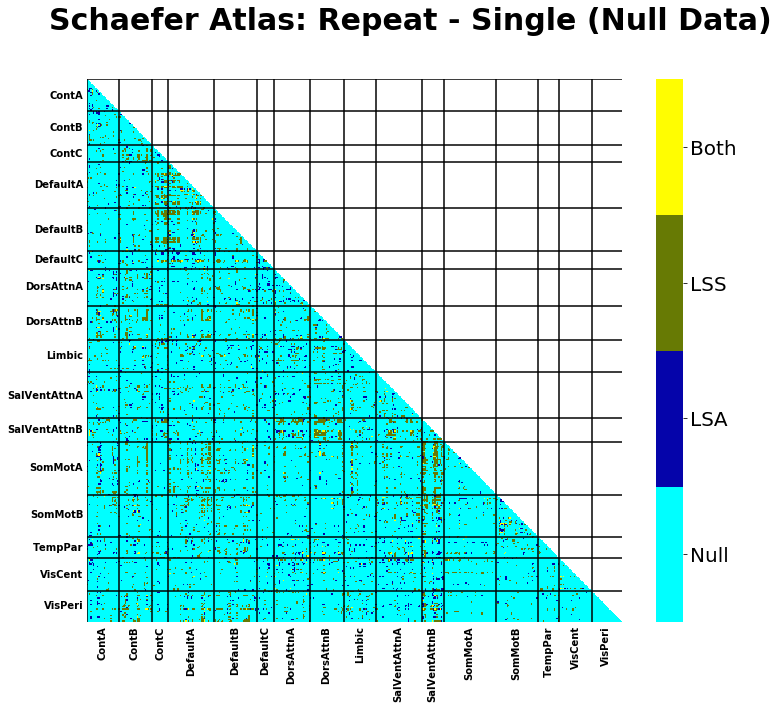

In [319]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['repeat'],
                       fb_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS)
fig.suptitle("Schaefer Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-repeatXsingle.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Activation Atlas: repeat - single (task)

Number of Positives lsa: 10 / 210
Number of Positives lss: 11 / 210
Number of overlapping positives: 0 / 210


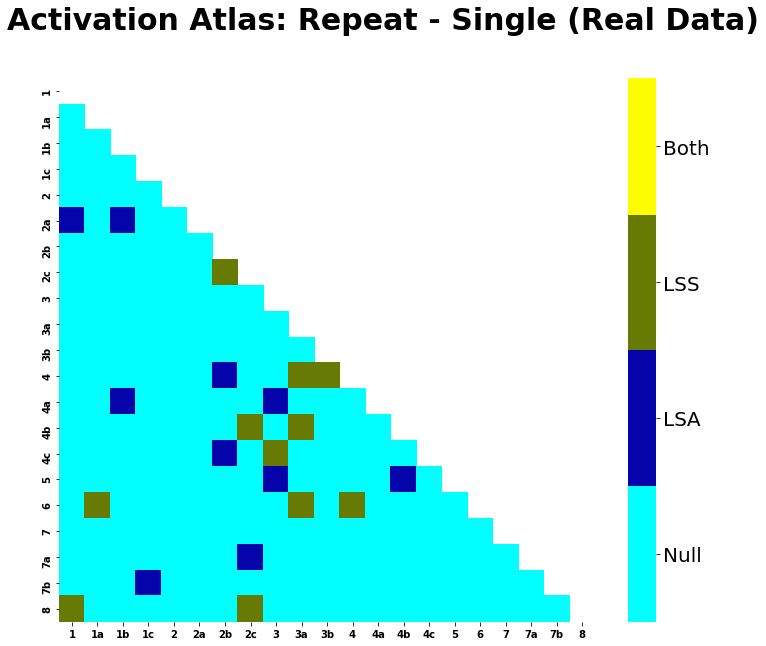

In [320]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['repeat'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['repeat'],
                       ts_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS)
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-repeatXsingle.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Activation Atlas: repeat - single (null)

Number of Positives lsa: 4 / 210
Number of Positives lss: 6 / 210
Number of overlapping positives: 0 / 210


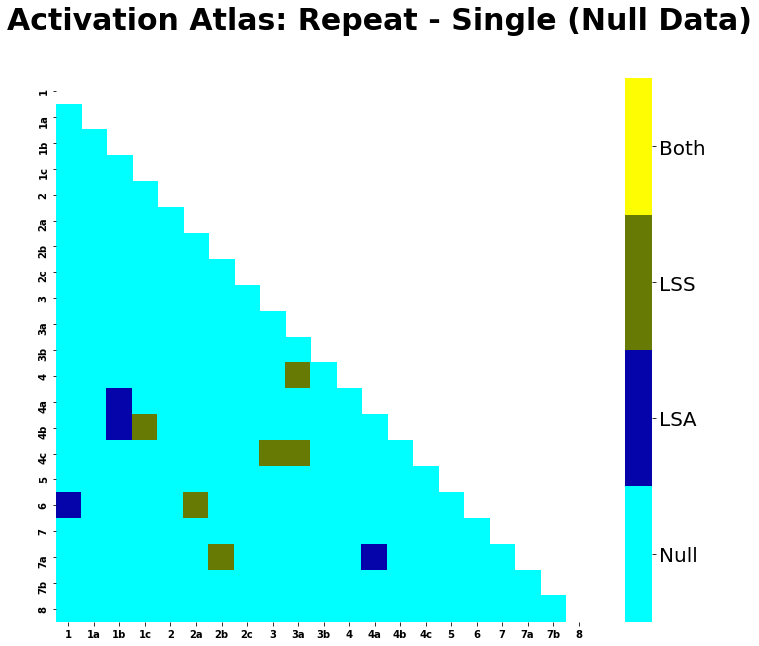

In [321]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['repeat'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['repeat'],
                       fb_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS)
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-repeatXsingle.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Schaefer Atlas: switch - repeat (task)

Number of Positives lsa: 126 / 79800
Number of Positives lss: 1053 / 79800
Number of overlapping positives: 3 / 79800


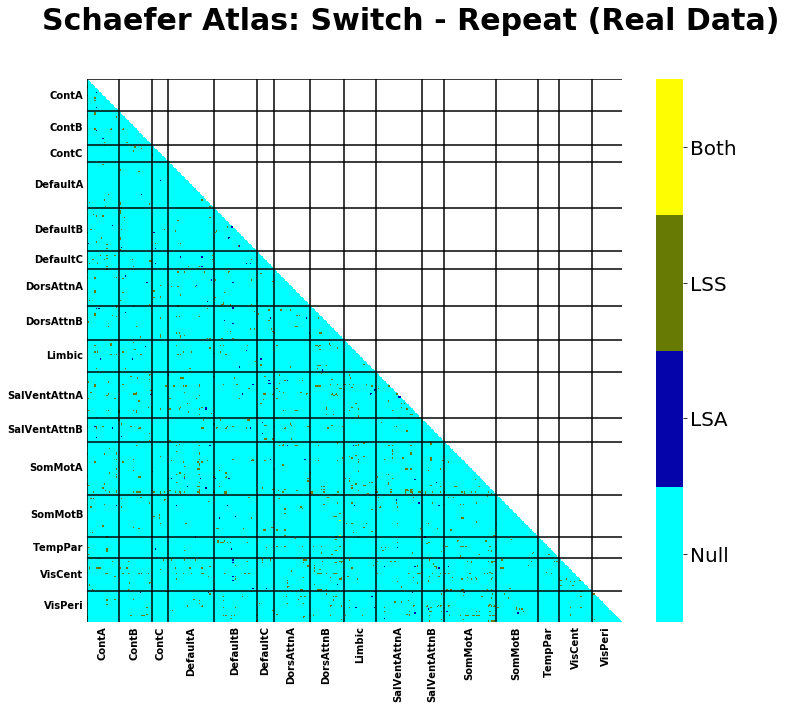

In [322]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lsa_objs['switch'],
                       ts_sch_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchXrepeat.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Schaefer Atlas: switch - repeat (null)

Number of Positives lsa: 285 / 79800
Number of Positives lss: 614 / 79800
Number of overlapping positives: 7 / 79800


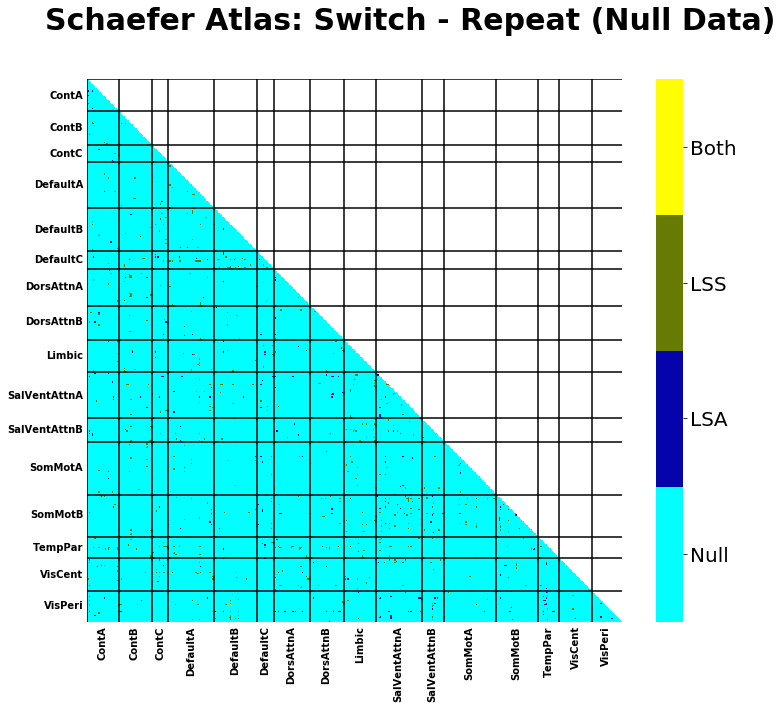

In [323]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['switch'],
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-switchXrepeat.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Activation Atlas: switch - repeat (task)

Number of Positives lsa: 0 / 210
Number of Positives lss: 3 / 210
Number of overlapping positives: 0 / 210


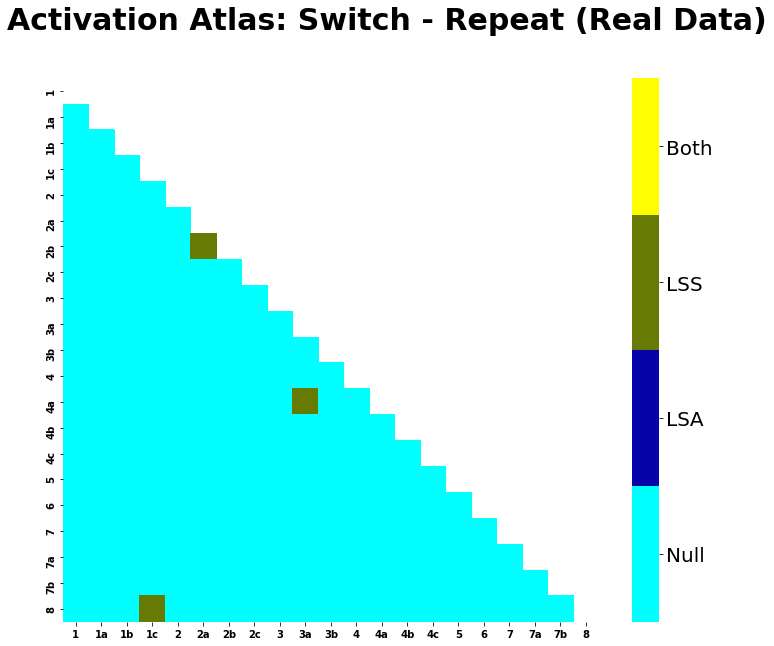

In [324]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       ts_act_lss_objs['repeat'],
                       ts_act_lsa_objs['switch'],
                       ts_act_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='activation', nthreads=N_THREADS)
fig.suptitle("Activation Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-switchXrepeat.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

### Activation Atlas: switch - repeat (null)

Number of Positives lsa: 1 / 210
Number of Positives lss: 2 / 210
Number of overlapping positives: 0 / 210


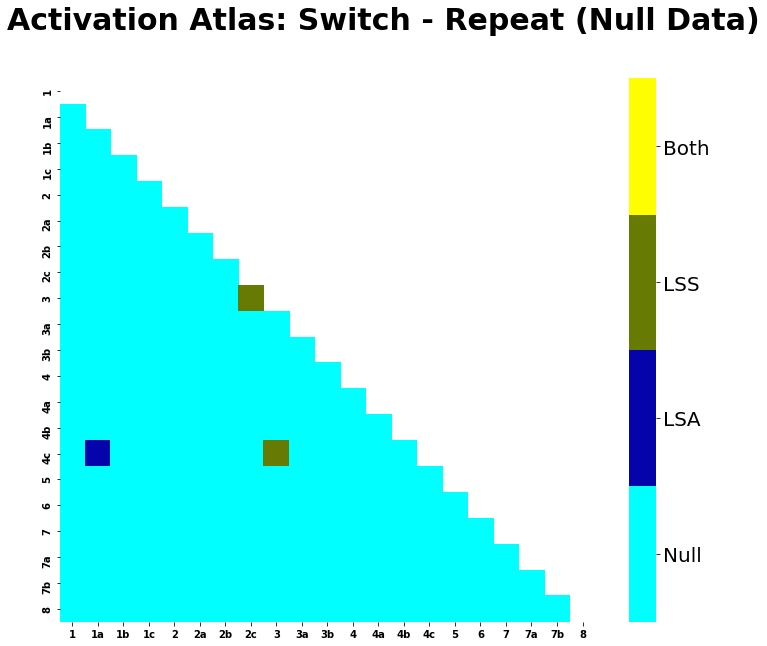

In [325]:
fig, _, _, = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['switch'],
                       fb_act_lss_objs['repeat'],
                       fb_act_lsa_objs['switch'],
                       fb_act_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='activation', nthreads=N_THREADS)
fig.suptitle("Activation Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-switchXrepeat.png'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

## Participation Coefficient (Prespecified Community Assignment)

The participation coefficient measures how much a parcel connects to all other parcels, with 1 meaning the parcel is connected to all other parcels equally.

I expect the participation coefficient to be greater (i.e., closer to 1) in the task switch relative to rest, especially in frontal-parietal networks.

**Note**: participation coefficient is calculated separately for positively and negatively signed correlations.
My hypothesis is only for the positively signed correlations.

In [ ]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_participation_coef,
                          [(f.path, f.entities['subject'], 'taskswitch', False) for f in ts_act_lss_objs['switch']])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
participant_coef_ts_df = pd.DataFrame.from_dict(dict_collector)
participant_coef_ts_df.head()

In [ ]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_participation_coef,
                          [(f.path, f.entities['subject'], 'fauxbold', False) for f in fb_act_lss_objs['switch']])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
participant_coef_fb_df = pd.DataFrame.from_dict(dict_collector)
participant_coef_fb_df.head()

In [ ]:
participant_coef_df = pd.concat([participant_coef_ts_df, participant_coef_fb_df])
participant_coef_pos_df = participant_coef_df.filter(regex=(".*_pos|task|participant_id"))
participant_coef_neg_df = participant_coef_df.filter(regex=(".*_neg|task|participant_id"))

### Positive Participation Coefficient

In [ ]:
participant_coef_pos_model = nf.model_corr_diff_mt(participant_coef_pos_df, N_THREADS)

In [ ]:
participant_coef_pos_model.head()

In [ ]:
p_values_sig2, p_value_fdr, _, _ = multipletests(participant_coef_pos_model['p_value'], alpha=0.05, method='fdr_bh')

In [ ]:
participant_coef_pos_model.loc[p_values_sig2]

In [ ]:
participant_coef_df.loc[participant_coef_df['task'] == 'taskswitch', 'DefaultA-LH_PCC_3_pos'].mean()

In [ ]:
participant_coef_df.loc[participant_coef_df['task'] == 'fauxbold', 'DefaultA-LH_PCC_3_pos'].mean()

### Discussion

There are significant differences between task and rest, but the most represented network is in the Default Mode network, with task showing a higher participation coefficient (as expected)

However, I should run the analysis again allowing the [communities to be decided by an algorithm rather than the schaefer network assignments](https://www.sciencedirect.com/science/article/pii/S0896627316305773?via%3Dihub)

### Negative Participation Coefficient

In [ ]:
participant_coef_neg_model = nf.model_corr_diff_mt(participant_coef_neg_df, N_THREADS)

In [ ]:
p_values_sig3, p_value_fdr, _, _ = multipletests(participant_coef_neg_model['p_value'], alpha=0.05, method='fdr_bh')

In [ ]:
participant_coef_neg_model.loc[p_values_sig3]

## Participation Coefficient (Louvain Community Assignment)

In [ ]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_participation_coef,
                          [(f.path, f.entities['subject'], 'taskswitch', True) for f in ts_sch_lss_objs['switch']])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
participant_coeflv_ts_df = pd.DataFrame.from_dict(dict_collector)
participant_coeflv_ts_df.head()

In [ ]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_participation_coef,
                          [(f.path, f.entities['subject'], 'fauxbold', True) for f in fb_sch_lss_objs['switch']])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
participant_coeflv_fb_df = pd.DataFrame.from_dict(dict_collector)
participant_coeflv_fb_df.head()

In [ ]:
participant_coeflv_df = pd.concat([participant_coeflv_ts_df, participant_coeflv_fb_df])
participant_coeflv_pos_df = participant_coeflv_df.filter(regex=(".*_pos|task|participant_id"))
participant_coeflv_neg_df = participant_coeflv_df.filter(regex=(".*_neg|task|participant_id"))

### Positive Participation Coefficient

In [ ]:
participant_coeflv_pos_model = nf.model_corr_diff_mt(participant_coeflv_pos_df, N_THREADS)

In [ ]:
participant_coeflv_pos_model.head()

In [ ]:
p_values_sig_lv_pos, p_value_fdr, _, _ = multipletests(participant_coeflv_pos_model['p_value'], alpha=0.05, method='fdr_bh')

In [ ]:
participant_coeflv_pos_model.loc[p_values_sig_lv_pos]

### Negative Participation Coefficient

In [ ]:
participant_coeflv_neg_model = nf.model_corr_diff_mt(participant_coeflv_neg_df, N_THREADS)
participant_coeflv_neg_model.head()

In [ ]:
p_values_sig_lv_neg, p_value_fdr, _, _ = multipletests(participant_coef_neg_model['p_value'], alpha=0.05, method='fdr_bh')

In [ ]:
participant_coeflv_neg_model.loc[p_values_sig_lv_neg]

## Clustering Coefficient
Clustering Coefficient measures the number of local highly clustered nodes (nodes that form triangles of connections).

I expect task to have a higher(?) clustering coefficient relative to rest.
This is a rather expensive computation

In [ ]:
OVERWRITE = False
CLUSTER_TASKSWITCH_FILE = './outputs/clustering_coefficient_taskswitch_switch.tsv'
CLUSTER_FAUXBOLD_FILE = './outputs/clustering_coefficient_fauxbold_switch.tsv'

In [ ]:

if os.path.isfile(CLUSTER_TASKSWITCH_FILE) and not OVERWRITE:
    clustering_coef_ts_df = pd.read_csv(CLUSTER_TASKSWITCH_FILE, sep='\t')
else:
    with Pool(N_THREADS) as p:
        sep_dicts = p.starmap(nf.calc_clustering_coef,
                              [(f.path, f.entities['subject'], 'taskswitch') for f in ts_sch_lss_objs['switch']])
        dict_collector = {
                k: [d.get(k) for d in sep_dicts]
                for k in set().union(*sep_dicts)}
    clustering_coef_ts_df = pd.DataFrame.from_dict(dict_collector)
    clustering_coef_ts_df.to_csv(CLUSTER_TASKSWITCH_FILE, sep='\t', index=False)

clustering_coef_ts_df.head()

In [ ]:
if os.path.isfile(CLUSTER_FAUXBOLD_FILE) and not OVERWRITE:
    clustering_coef_fb_df = pd.read_csv(CLUSTER_FAUXBOLD_FILE, sep='\t')
else:
    with Pool(N_THREADS) as p:
        sep_dicts = p.starmap(nf.calc_clustering_coef,
                              [(f.path, f.entities['subject'], 'fauxbold') for f in fb_sch_lss_objs['switch']])
        dict_collector = {
                k: [d.get(k) for d in sep_dicts]
                for k in set().union(*sep_dicts)}
    clustering_coef_fb_df = pd.DataFrame.from_dict(dict_collector)
    clustering_coef_fb_df.to_csv(CLUSTER_FAUXBOLD_FILE, sep='\t', index=False)
clustering_coef_fb_df.head()

In [ ]:
clustering_coef_df = pd.concat([clustering_coef_ts_df, clustering_coef_fb_df])

In [ ]:
clustering_coef_model = nf.model_corr_diff_mt(clustering_coef_df, N_THREADS)
clustering_coef_model.head()

In [ ]:
p_values_sig4, p_value_fdr, _, _ = multipletests(clustering_coef_model['p_value'], alpha=0.05, method='fdr_bh')

In [ ]:
clustering_coef_model.loc[p_values_sig4]

## Modularity
Modularity is a measure of within community connections relative to outside community connections.
I expect task to have a lower modularity relative to rest.

In [ ]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_modularity,
                          [(f.path, f.entities['subject'], 'taskswitch') for f in ts_sch_lss_objs['switch']])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
modularity_ts_df = pd.DataFrame.from_dict(dict_collector)
modularity_ts_df.head()

In [ ]:
with Pool(N_THREADS) as p:
    sep_dicts = p.starmap(nf.calc_modularity,
                          [(f.path, f.entities['subject'], 'fauxbold') for f in fb_sch_lss_objs['switch']])
    dict_collector = {
            k: [d.get(k) for d in sep_dicts]
            for k in set().union(*sep_dicts)}
modularity_fb_df = pd.DataFrame.from_dict(dict_collector)
modularity_fb_df.head()

In [ ]:
modularity_df = pd.concat([modularity_ts_df, modularity_fb_df])

In [ ]:
nf._run_model(modularity_df, "modularity")

In [ ]:
nf._run_model(modularity_df, "modularity", nuisance_cols=['num_ci', 'num_nan_rois'])

## Investigate Beta Correlations between LSS and LSA

In [64]:
ts_act_lss_bs_objs = nf.get_layout_objects(lss_act_layout,
                                           ['switch', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="taskswitch")
ts_act_lsa_bs_objs = nf.get_layout_objects(lsa_act_layout,
                                           ['switch', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="taskswitch")

In [65]:
masker = NiftiLabelsMasker(ACT_ATLAS)

In [66]:
collector = {}
for lss, lsa in zip(ts_act_lss_bs_objs['switch'], ts_act_lsa_bs_objs['switch']):
    lss_ts = masker.fit_transform(lss.path)
    lsa_ts = masker.fit_transform(lsa.path)
    correlations = []
    for col in range(lss_ts.shape[1]):
        correlations.append(np.corrcoef(lss_ts[:,col], lsa_ts[:,col])[1,0])
    collector[lss.entities['subject']] = correlations

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict


In [69]:
columns = nf._read_adj_matrix(fb_act_lss_objs['switch'][0].path).columns
lss_lsa_beta_series_corr = pd.DataFrame.from_dict(collector, orient='index', columns=columns)
lss_lsa_beta_series_corr['average_correlation'] = lss_lsa_beta_series_corr.mean(axis=1)
lss_lsa_beta_series_corr.reset_index(inplace=True)
lss_lsa_beta_series_corr.head()

,index,1,1a,1b,1c,2,2a,2b,2c,3,...,4a,4b,4c,5,6,7,7a,7b,8,average_correlation
0,GE120001,0.902158,0.718729,0.813628,0.783513,0.805076,0.604559,0.771763,0.800634,0.846808,...,0.788652,0.739507,0.740293,0.706338,0.731803,0.808513,0.823656,0.654610,0.818216,0.766809
1,GE120002,0.778338,0.823437,0.597576,0.583363,0.640395,0.852702,0.831235,0.842090,0.687427,...,0.882585,0.690386,0.823524,0.761870,0.670465,0.622443,0.563976,0.378567,0.904216,0.715981
2,GE120003,0.110406,-0.524328,0.239468,0.664142,-0.350989,0.514033,-0.000558,-0.476666,0.468404,...,0.128233,0.743875,-0.510498,-0.120001,-0.431371,-0.370438,0.707513,0.621620,-0.040808,-0.026875
3,GE120004,0.760017,0.815351,0.645294,0.664141,0.657455,0.789183,0.769173,0.702927,0.744540,...,0.702052,0.811049,0.821552,0.418739,0.751001,0.665065,0.488008,0.780618,0.788424,0.714220
4,GE120005,0.848964,0.711097,0.539673,0.357270,0.469186,0.335240,0.316226,0.542110,0.396571,...,0.651148,0.561452,0.713530,0.217976,0.771670,0.834567,0.617949,0.728801,0.492653,0.532375


In [77]:
lss_lsa_beta_combine = pd.merge(
    lss_lsa_beta_series_corr,
    bold_qa_select.query("task == 'taskswitch'"),
    how='left',
    left_on='index',
    right_on='participant_id')

In [80]:
lss_lsa_beta_combine['hue'] = lss_lsa_beta_combine['index'].isin(good_participants)

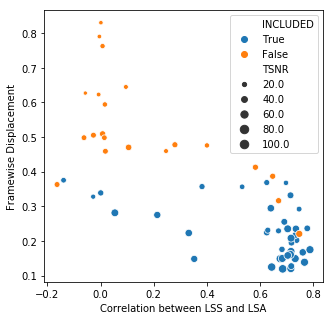

In [83]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='average_correlation', y='fd_mean', size='tsnr', hue='hue', hue_order=[True, False], data=lss_lsa_beta_combine, ax=ax)
ax.set_xlabel("Correlation between LSS and LSA");
ax.set_ylabel("Framewise Displacement");
ax.legend_.texts[0].set_text("INCLUDED");
ax.legend_.texts[3].set_text("TSNR");

A high correlation between LSS and LSA means the methods agreed with each other.
The methods do not agree as much as motion increases and TSNR decreases.

## Validation Strategy

In [ ]:
participants = repeat_single_wide_df['participant_id'].unique()

In [ ]:
np.random.shuffle(participants)
test_participants = participants[:30]
validation_participants = participants[30:]

In [ ]:
test_df = repeat_single_wide_df[repeat_single_wide_df['participant_id'].isin(test_participants)]

In [ ]:
test_model_df = nf.model_corr_diff_mt(test_df, N_THREADS)

In [ ]:
p_value_test_df = nf.make_symmetric_df(test_model_df, "p_value")

In [ ]:
p_values = p_value_test_df.values[np.tril_indices(400, k=-1)]
(p_values < 0.05).sum()
p_value_locations = p_values < 0.05

In [ ]:
validation_df = repeat_single_wide_df[repeat_single_wide_df['participant_id'].isin(validation_participants)]

In [ ]:
validation_model_df = nf.model_corr_diff_mt(validation_df, N_THREADS)

In [ ]:
p_value_validation_df = nf.make_symmetric_df(validation_model_df, "p_value")

In [ ]:
p_valid_values = p_value_validation_df.values[np.tril_indices(400, k=-1)]
(p_valid_values < 0.05).sum()
p_valid_value_locations = p_valid_values < 0.05

In [ ]:
tn, fp, fn, tp = confusion_matrix(p_value_locations, p_valid_value_locations).ravel()

In [ ]:
tp / fp